This notebook explores an idea for finding the scan offset when the precursor is absent and cannot be used as a guide.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from scipy.signal import correlate

In [2]:
database_name = 'z:/wilding-mcbride/processing/UPS2_MS1_MS2_ratio_experiment_20180621_1xMS2/UPS2_MS1_MS2_ratio_experiment_20180621_1xMS2-features-11359-12980.sqlite'

In [3]:
source_conn = sqlite3.connect(database_name)
features_df = pd.read_sql_query("select feature_id,base_peak_id from feature_base_peaks order by feature_id ASC;", source_conn)
source_conn.close()

In [5]:
features_df

,feature_id,base_peak_id
0,11359,1
1,11360,1
2,11361,2
3,11362,1
4,11363,2
5,11364,1
6,11365,1
7,11366,1
8,11367,1
9,11368,1


In [6]:
feature_id = 11377
base_peak_id = features_df[features_df.feature_id==feature_id].base_peak_id.values[0]

In [92]:
source_conn = sqlite3.connect(database_name)
base_peak_df = pd.read_sql_query("select centroid_scan from ms1_feature_region_peaks where feature_id={} and peak_id={}".format(feature_id,base_peak_id), source_conn)
source_conn.close()

In [97]:
base_peak_centroid_scan = base_peak_df.centroid_scan.values[0]
base_peak_centroid_scan

114.87449915978159

In [74]:
source_conn = sqlite3.connect(database_name)
ms2_peak_df = pd.read_sql_query("select peak_id,centroid_scan from ms2_peaks where feature_id={} order by peak_id ASC".format(feature_id), source_conn)
source_conn.close()

In [75]:
ms2_peak_df

,peak_id,centroid_scan
0,1,119
1,2,119
2,3,125
3,4,118
4,5,118
5,6,124
6,7,118
7,8,117
8,9,118
9,10,118


In [76]:
ms2_peak_id = 2

In [80]:
ms2_peak_centroid_scan = ms2_peak_df[ms2_peak_df.peak_id == ms2_peak_id].centroid_scan.values[0]
ms2_peak_centroid_scan

119

In [7]:
source_conn = sqlite3.connect(database_name)
feature_base_peak_points_df = pd.read_sql_query("select point_id,mz,scan,intensity from summed_ms1_regions where feature_id={} and peak_id={} order by scan ASC".format(feature_id,base_peak_id), source_conn)
ms2_peak_points_df = pd.read_sql_query("select peak_id,point_id,mz,scan,intensity from summed_ms2_regions where feature_id={} order by peak_id,scan ASC;".format(feature_id), source_conn)
source_conn.close()

In [8]:
feature_base_peak_points_df

,point_id,mz,scan,intensity
0,1,749.795750,99,1812
1,5,749.749336,101,5842
2,8,749.749599,102,2578
3,10,749.773507,103,6828
4,13,749.772950,104,12874
5,16,749.786279,105,14238
6,19,749.792099,106,23318
7,23,749.784248,107,31678
8,27,749.784854,108,16595
9,30,749.792421,109,15401


In [9]:
ms2_peak_points_to_plot_df = ms2_peak_points_df[(ms2_peak_points_df.peak_id>=1000) & (ms2_peak_points_df.peak_id<=1100)]

In [10]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

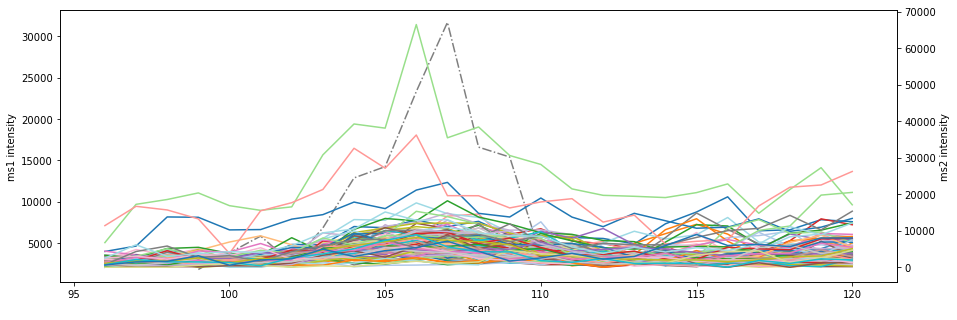

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(feature_base_peak_points_df.scan, feature_base_peak_points_df.intensity, marker='', linestyle='-.', ms=5, color='tab:gray', label='frame')
groups = ms2_peak_points_to_plot_df.groupby('peak_id')
for i, (name, group) in enumerate(groups):
    ax2.plot(group.scan, group.intensity, color=tableau20[i%len(tableau20)], label=name)
# plt.legend(loc='best')
ax1.set_ylabel('ms1 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms2 intensity')
plt.margins(0.06)
plt.show()

In [68]:
ms2_peak_df = ms2_peak_points_df.loc[(ms2_peak_points_df.peak_id==ms2_peak_id),['scan','intensity']]

In [69]:
base_peak_df = feature_base_peak_points_df[['scan','intensity']]

In [70]:
combined_df = pd.merge(base_peak_df, ms2_peak_df, on='scan', how='outer', suffixes=('_base', '_ms2')).sort_values(by='scan')
combined_df.intensity_base.fillna(0, inplace=True)
combined_df.intensity_base = combined_df.intensity_base.astype(int)

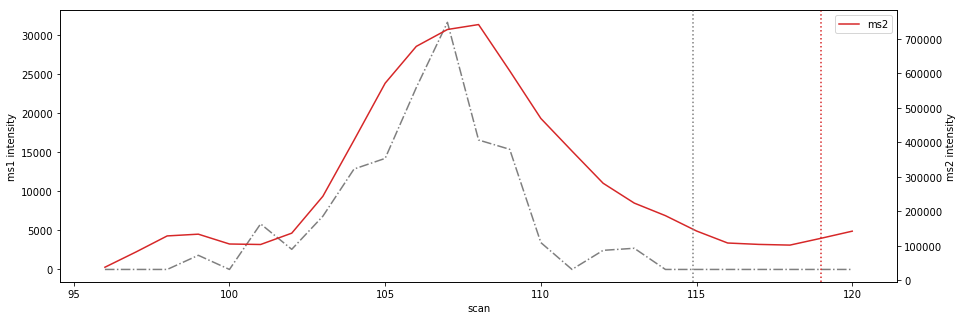

In [98]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(combined_df.scan, combined_df.intensity_base, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax2.plot(combined_df.scan, combined_df.intensity_ms2, marker='', linestyle='-', ms=5, color='tab:red', label='ms2')
plt.axvline(x=ms2_peak_centroid_scan, linestyle=':', color='tab:red')
plt.axvline(x=base_peak_centroid_scan, linestyle=':', color='tab:gray')
plt.legend(loc='best')
ax1.set_ylabel('ms1 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms2 intensity')
plt.margins(0.06)
plt.show()

In [16]:
offset = np.argmax(correlate(combined_df.intensity_base, combined_df.intensity_ms2)) - (len(combined_df.intensity_base)-1)  # wrt indexes
offset

-1

In [17]:
from scipy.ndimage.interpolation import shift
adjusted_intensity_ms2 = shift(combined_df.intensity_ms2, offset, cval=0)

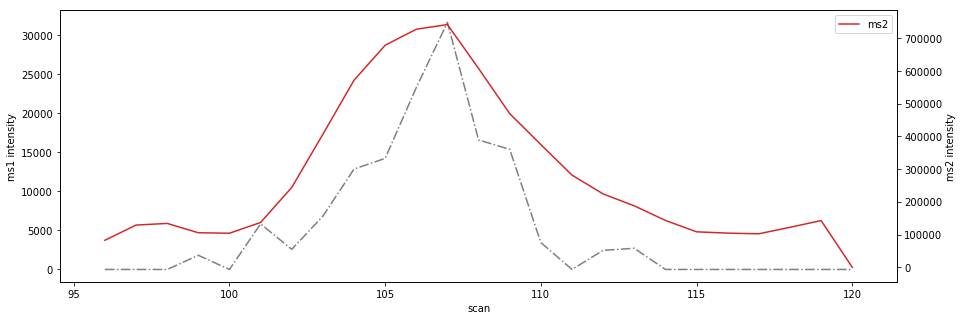

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(combined_df.scan, combined_df.intensity_base, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax2.plot(combined_df.scan, adjusted_intensity_ms2, marker='', linestyle='-', ms=5, color='tab:red', label='ms2')
plt.legend(loc='best')
ax1.set_ylabel('ms1 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms2 intensity')
plt.margins(0.06)
plt.show()

### Plot a histogram of ms2 peak shift

In [60]:
source_conn = sqlite3.connect(database_name)
ms2_peaks_df = pd.read_sql_query("select peak_id,intensity,centroid_scan from ms2_peaks where feature_id={} order by peak_id ASC;".format(feature_id), source_conn)
source_conn.close()

In [62]:
ms2_peaks_df_offset = []
ms2_peaks_df_adjusted_correlation = []

for index,row in ms2_peaks_df.iterrows():
    ms2_peak_df = ms2_peak_points_df.loc[(ms2_peak_points_df.peak_id==row.peak_id),['scan','intensity']]
    combined_df = pd.merge(base_peak_df, ms2_peak_df, on='scan', how='outer', suffixes=('_base', '_ms2')).sort_values(by='scan')
    combined_df.intensity_base.fillna(0, inplace=True)
    combined_df.intensity_base = combined_df.intensity_base.astype(int)
    combined_df.intensity_ms2.fillna(0, inplace=True)
    combined_df.intensity_ms2 = combined_df.intensity_base.astype(int)
    offset = np.argmax(correlate(combined_df.intensity_base, combined_df.intensity_ms2)) - (len(combined_df.intensity_base)-1)
    adjusted_intensity_ms2 = shift(combined_df.intensity_ms2, offset, cval=0)
    ms2_peaks_df_offset.append(offset)
    ms2_peaks_df_adjusted_correlation.append(np.corrcoef(combined_df.intensity_base, adjusted_intensity_ms2)[1,0])
ms2_peaks_df['offset'] = pd.Series(ms2_peaks_df_offset)
ms2_peaks_df['adjusted_correlation'] = pd.Series(ms2_peaks_df_adjusted_correlation)


In [63]:
ms2_peaks_df

,peak_id,intensity,centroid_scan,offset,adjusted_correlation
0,1,14907678,119,-2,0.618965
1,2,15721475,119,-2,0.618965
2,3,10297068,125,-2,0.618965
3,4,9673655,118,-2,0.618965
4,5,9541065,118,-2,0.618965
5,6,7874055,124,-2,0.618965
6,7,8309876,118,-2,0.618965
7,8,8763879,117,-2,0.618965
8,9,7461278,118,-2,0.618965
9,10,8978822,118,-2,0.618965


C:\Users\wilding-mcbride.d\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


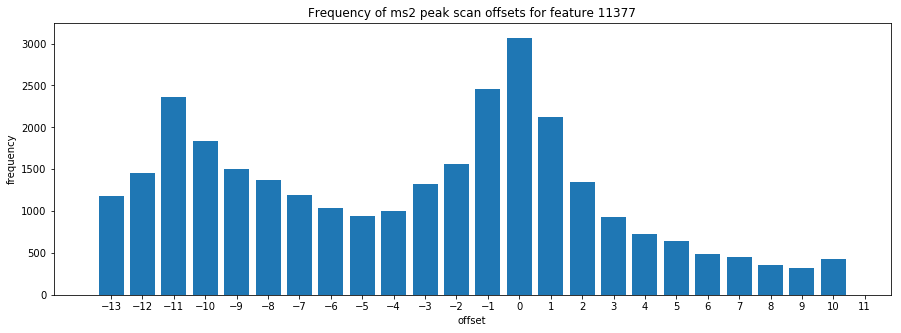

In [22]:
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.hist(ms2_peaks_df.offset, bins=np.arange(ms2_peaks_df.offset.min(), ms2_peaks_df.offset.max()+1), align='left', rwidth=0.8)
plt.legend(loc='best')
plt.xlabel('offset')
plt.ylabel('frequency')
plt.title('Frequency of ms2 peak scan offsets for feature {}'.format(feature_id))
plt.margins(0.06)
plt.xticks(np.arange(ms2_peaks_df.offset.min(), ms2_peaks_df.offset.max()+1))
# plt.xlim([ms2_peaks_df.offset.min(), ms2_peaks_df.offset.max()])
plt.show()

In [23]:
ms2_peaks_df["offset"].value_counts().to_frame().index[0]

0

### Is this consistent when we _can_ find the precursor?

In [48]:
feature_id = 11360

In [49]:
db_conn = sqlite3.connect(database_name)
ms2_peak_matches_df = pd.read_sql_query("select * from precursor_ms2_peak_matches where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [50]:
ms2_peak_matches_df

,feature_id,base_peak_id,base_peak_rt,ms2_peak_id,mz_centroid,mz_delta,scan_delta
0,11360,1,531.2,2109,618.770095,0.000095,-1.874499


In [51]:
ms2_peak_id = ms2_peak_matches_df[ms2_peak_matches_df.feature_id==feature_id].ms2_peak_id.values[0]
ms2_peak_df = ms2_peak_points_df.loc[(ms2_peak_points_df.peak_id==ms2_peak_id),['scan','intensity']]

In [52]:
combined_df = pd.merge(base_peak_df, ms2_peak_df, on='scan', how='outer', suffixes=('_base', '_ms2')).sort_values(by='scan')
combined_df.intensity_base.fillna(0, inplace=True)
combined_df.intensity_base = combined_df.intensity_base.astype(int)

In [53]:
combined_df

,scan,intensity_base,intensity_ms2
13,96,0,1643
14,97,0,2173
15,98,0,1598
0,99,1812,1878
16,100,0,1121
1,101,5842,2546
2,102,2578,3573
3,103,6828,2488
4,104,12874,4757
5,105,14238,3280


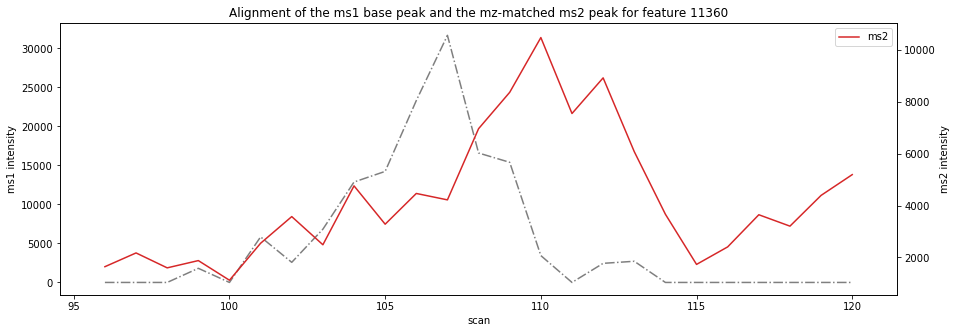

In [54]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(combined_df.scan, combined_df.intensity_base, marker='', linestyle='-.', ms=5, color='tab:gray', label='base')
ax2.plot(combined_df.scan, combined_df.intensity_ms2, marker='', linestyle='-', ms=5, color='tab:red', label='ms2')
plt.legend(loc='best')
ax1.set_ylabel('ms1 intensity')
ax1.set_xlabel('scan')
ax2.set_ylabel('ms2 intensity')
plt.title('Alignment of the ms1 base peak and the mz-matched ms2 peak for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

In [55]:
offset = np.argmax(correlate(combined_df.intensity_base, combined_df.intensity_ms2)) - (len(combined_df.intensity_base)-1)  # wrt indexes
offset

-3

In [56]:
summed_intensity_by_offset = ms2_peaks_df.groupby(['offset'])['intensity'].agg('sum')

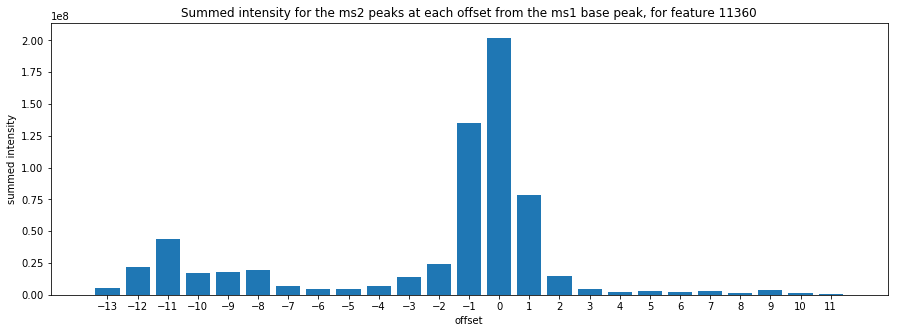

In [57]:
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.bar(summed_intensity_by_offset.index, summed_intensity_by_offset, align='center', width=0.8)
plt.legend(loc='best')
plt.xlabel('offset')
plt.ylabel('summed intensity')
plt.title('Summed intensity for the ms2 peaks at each offset from the ms1 base peak, for feature {}'.format(feature_id))
plt.margins(0.06)
plt.xticks(np.arange(ms2_peaks_df.offset.min(), ms2_peaks_df.offset.max()+1))
plt.show()

In [58]:
summed_correlation_by_offset = ms2_peaks_df.groupby(['offset'])['adjusted_correlation'].agg('sum')

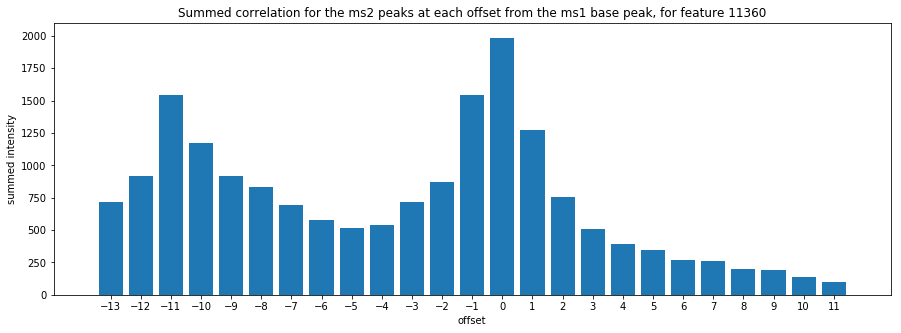

In [59]:
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.bar(summed_correlation_by_offset.index, summed_correlation_by_offset, align='center', width=0.8)
plt.legend(loc='best')
plt.xlabel('offset')
plt.ylabel('summed intensity')
plt.title('Summed correlation for the ms2 peaks at each offset from the ms1 base peak, for feature {}'.format(feature_id))
plt.margins(0.06)
plt.xticks(np.arange(ms2_peaks_df.offset.min(), ms2_peaks_df.offset.max()+1))
plt.show()